# Visión Computacional Basada en Redes Neuronales Artificiales
## Grupo 04 - Trabajo Práctico Especial

Integrantes del grupo:

* Gastón Peña
* Stella Vilca






In [1]:
# montamos la unidad de Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

# Imports necesarios
from os import makedirs
from torchvision import datasets, transforms
import torch

# carpeta donde van a guardar los datos
from os import makedirs
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Grupo 04' ## < EDITAR NÚMERO DE GRUPO
makedirs(datasets_folder, exist_ok=True)

# NO TOCAR EL CÓDIGO DE ACÁ ABAJO, ES PARA BAJAR DATOS NUEVOS!
new_datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/'
makedirs(new_datasets_folder, exist_ok=True)
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_data.npy*
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_labels.npy*
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_labels.npy
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/

Mounted at /content/gdrive/
--2025-11-25 19:41:16--  https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy [following]
--2025-11-25 19:41:17--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6208640 (5.9M) [application/octet-stream]
Saving to: ‘/content/gdrive/My Drive/Colab Notebooks/Computer Vision/cifar10.1_v4_data.npy’

cifar10.1_v4_data.n 100%[=========

In [2]:
##!pip install -q torch torchvision

from os import makedirs
import numpy as np
import copy

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ColorJitter, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader # Import DataLoader

In [3]:
# Cargamos CIFAR10 sin normalización (solo ToTensor) para calcular estadísticas
temp_transform = transforms.Compose([transforms.ToTensor()])
tensor_cifar10 = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=temp_transform)

# Apilamos todas las imágenes en un tensor gigante
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print(f"Shape del tensor de imágenes: {imgs.shape}")
print(f"Shape después de view: {imgs.view(3, -1).size()}")

# Calculamos la media de cada canal
mean = imgs.view(3, -1).mean(dim=1)
print(f"Media por canal (R, G, B): {mean}")

# Calculamos la desviación estándar
std = imgs.view(3, -1).std(dim=1)
print(f"Desviación estándar por canal (R, G, B): {std}")

Shape del tensor de imágenes: torch.Size([3, 32, 32, 50000])
Shape después de view: torch.Size([3, 51200000])
Media por canal (R, G, B): tensor([0.4914, 0.4822, 0.4465])
Desviación estándar por canal (R, G, B): tensor([0.2470, 0.2435, 0.2616])


## 1. Preprocesamiento Compose()


In [4]:
## list_of_training_transformations = [
##     transforms.RandomCrop(32, padding=4), # Hace un recorte aleatorio de 32x32 agregando un padding previo de 4 píxeles.Esto simula pequeños desplazamientos y zoom in/out, aumentando la robustez del modelo.
##     transforms.RandomHorizontalFlip(), # Invierte horizontalmente la imagen con probabilidad 0.5. Es la transformación más efectiva en CIFAR-10 porque muchos objetos son simétricos en este eje.
##     transforms.ToTensor(),
##     transforms.Normalize(mean, std),
## ]
list_of_training_transformations = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),

    # NUEVA 1: ColorJitter - Variaciones de color realistas
    transforms.ColorJitter(
        brightness=0.2,    # ±20% brillo
        contrast=0.2,      # ±20% contraste
        saturation=0.2,    # ±20% saturación
        hue=0.1           # ±10% matiz
    ),

    transforms.ToTensor(),
    transforms.Normalize(mean, std),

    # NUEVA 2: RandomErasing (Cutout) - Oclusión parcial
    transforms.RandomErasing(
        p=0.5,                    # 50% de probabilidad
        scale=(0.02, 0.15),       # Área del recorte: 2%-15% de la imagen
        ratio=(0.3, 3.3),         # Relación ancho/alto
        value='random'            # Relleno con valores aleatorios
    ),
]


# Transformaciones para TEST/VALIDACIÓN: solo normalización + estandarización
list_of_test_transformations = [
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

# Generamos las transformaciones compuestas
training_transformations = transforms.Compose(list_of_training_transformations)
test_transformations = transforms.Compose(list_of_test_transformations)

# Descargamos/cargamos los datasets finales con todas las transformaciones
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

print(f"Dataset de entrenamiento: {len(cifar10_training)} imágenes")
print(f"Dataset de validación: {len(cifar10_validation)} imágenes")

Dataset de entrenamiento: 50000 imágenes
Dataset de validación: 10000 imágenes


In [5]:
# y le pedimos a cifar10 el elemento 99.
data_sample = cifar10_training[99]
print(data_sample)

(tensor([[[-1.9416e+00, -1.9416e+00, -1.9416e+00,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00],
         [ 5.9837e-01,  2.0150e-01,  8.0474e-01,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00],
         [ 9.4761e-01,  5.1899e-01,  1.5667e+00,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00],
         ...,
         [ 8.0474e-01,  1.9795e+00,  2.0588e+00,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00],
         [ 7.0949e-01,  2.0588e+00,  1.9795e+00,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00],
         [-5.7636e-01,  1.0625e-01,  2.1737e-01,  ..., -1.9416e+00,
          -1.9416e+00, -1.9416e+00]],

        [[-1.9319e+00, -1.9319e+00, -1.9319e+00,  ..., -1.9319e+00,
          -1.9319e+00, -1.9319e+00],
         [ 1.9407e-01, -1.2805e-01,  4.5177e-01,  ..., -1.9319e+00,
          -1.9319e+00, -1.9319e+00],
         [ 4.6787e-01,  1.2965e-01,  1.1926e+00,  ..., -1.9319e+00,
          -1.9319e+00, -1.9319e+00],
         ...,
         [-1.6581e+00, -

In [6]:
#Verificamos que es un tensor y label
img_t, label = cifar10_training[99]
print(type(img_t))
print(type(label))

<class 'torch.Tensor'>
<class 'int'>


## 2. Arquitectura de la Red Convolucional

In [7]:
class G4_CIFAR10_CNN(nn.Module): ## AirplanesAndBirdsCNN
  '''
  Una primera red neuronal convolucional
  '''

  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()

    # ----- Bloque 1 -----
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv1 = nn.BatchNorm2d(num_features=32)


    # a la capa convolucional le tenemos que sacar el bias porque está de gusto
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv2 = nn.BatchNorm2d(num_features=64)

    # Primer MaxPool después de conv2

    # ----- Bloque 2 -----
    # capa convolucional 3
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv3 = nn.BatchNorm2d(num_features=128)

    # NUEVA CAPA CONVOLUCIONAL (conv4)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv4 = nn.BatchNorm2d(128)

    # Segundo MaxPool después de conv4

    # Tamaño después de dos poolings:
    # 32x32 → 16x16 → 8x8
    # y 128 filtros

    # con eso alimentamos la capa fully connected
    self.fc1 = nn.Linear(8 * 8 * 128, 256,bias=False)
    # y como la salida es un vector, tenemos que usar batch normalization 1d
    self.batch_norm_fc1 = nn.BatchNorm1d(num_features=256)

    # Dropout con probabilidad 0.3
    self.dropout = nn.Dropout(p=0.3)

    # y de esas 256 features generaremos 10 scores
    self.fc2 = nn.Linear(256, 10)
    # que pasaremos por la capa softmax para obtener probabilidades
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, x):
    '''
    Método que implementa el forward pass
    '''
    # la capa de batch normalization se aplica justo después de la convolución
    # y antes de la activation function
    # ----- Bloque 1 -----
    out = F.relu(self.batch_norm_conv1(self.conv1(x)))
    out = F.relu(self.batch_norm_conv2(self.conv2(out)))
    out = F.max_pool2d(out, 2)   # 32x32 → 16x16

    # ----- Bloque 2 -----
    out = F.relu(self.batch_norm_conv3(self.conv3(out)))

   # Nueva capa
    out = F.relu(self.batch_norm_conv4(self.conv4(out)))
    out = F.max_pool2d(out, 2)   # 16x16 → 8x8


    out = out.view(-1, 8 * 8 * 128)

    # capa fully connected
    out = torch.relu(self.batch_norm_fc1(self.fc1(out)))

    # dropout solo en entrenamiento (PyTorch lo maneja solo)
    out = self.dropout(out)

    # y después por la última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.__call__(inputs))

## Early Stopping

In [8]:
# Clase Early Stopping (definir antes del training loop)

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        self.save_path = save_path

    def __call__(self, model, val_loss):
        # Primera vez
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            torch.save(self.best_model, self.save_path)     # ← GUARDA
        # Mejoró
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            torch.save(self.best_model, self.save_path)     # ← GUARDA
        # No mejoró
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on epoch"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True

        self.status = f"Patience: {self.counter}/{self.patience}"
        return False


## 3. Training Loop

In [9]:
# Función de training loop modificada con ReduceLROnPlateau
def G4_training_loop(n_epochs, optimizer, model, loss_fn, train_loader, validation_loader, device, is_fully_connected=False, early_stopping_patience=None, scheduler=None):

    training_loss_per_epoch = []
    validation_loss_per_epoch = []
    training_accuracy_per_epoch = []
    validation_accuracy_per_epoch = []

    # Inicializar early stopping si se especifica patience
    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.001, restore_best_weights=True) if early_stopping_patience else None

    for epoch in range(1, n_epochs + 1):

        # ==========================
        #        TRAINING
        # ==========================

        loss_train = 0.0
        total = 0
        correct = 0
        model.train()

        for imgs, labels in train_loader:

            if is_fully_connected:
                batch_size = imgs.shape[0]
                imgs = imgs.view(batch_size, -1)

            imgs = imgs.to(device)

            # ----- FIX CRÍTICO -----
            if not torch.is_tensor(labels):
                labels = torch.tensor(labels)
            labels = labels.view(-1)      # <--- evita batch_size = 0
            labels = labels.to(device)
            # ------------------------

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # accuracy (sin softmax)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += int((predicted == labels).sum())

        training_loss_per_epoch.append(loss_train / len(train_loader))
        training_accuracy_per_epoch.append(correct / total)

        # ==========================
        #       VALIDATION
        # ==========================

        loss_val = 0.0
        total = 0
        correct = 0
        model.eval()

        with torch.no_grad():
            for imgs, labels in validation_loader:

                if is_fully_connected:
                    batch_size = imgs.shape[0]
                    imgs = imgs.view(batch_size, -1)

                imgs = imgs.to(device)

                # ----- FIX CRÍTICO -----
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
                labels = labels.view(-1)
                labels = labels.to(device)
                # ------------------------

                outputs = model(imgs)

                loss = loss_fn(outputs, labels)
                loss_val += loss.item()

                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += int((predicted == labels).sum())

        validation_loss_per_epoch.append(loss_val / len(validation_loader))
        validation_accuracy_per_epoch.append(correct / total)

        # Actualizar scheduler si existe
        if scheduler:
            scheduler.step(validation_loss_per_epoch[-1])

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}:")
            print(f" ---> Loss: Training {training_loss_per_epoch[-1]:.4f} - Validation {validation_loss_per_epoch[-1]:.4f}")
            print(f" ---> Accuracy: Training {training_accuracy_per_epoch[-1]:.4f} - Validation {validation_accuracy_per_epoch[-1]:.4f}")
            if scheduler:
                print(f" ---> Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
            if early_stopping:
                print(f" ---> {early_stopping.status}")

        # Verificar early stopping
        if early_stopping:
            if early_stopping(model, validation_loss_per_epoch[-1]):
                print(f"\n⚠️ Early Stopping activado en epoch {epoch}")
                print(f"Mejor validation loss: {early_stopping.best_loss:.4f}")
                break

    return model, training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch

## Plot de Loss y accuracy por epoch

In [10]:
import matplotlib.pyplot as plt

def plot_training_statistics(training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch):
  '''
  Plotea las estadísticas sobre datos de entrenamiento y validación
  (loss function y valores de accuracy)
  '''

  # creamos plots para la loss y el accuracy
  fig, axes = plt.subplots(1, 2)
  # graficamos la evolución de la loss de entrenamiento y la de validación
  axes[0].plot(training_loss_per_epoch, color='blue')
  axes[0].plot(validation_loss_per_epoch, color='red')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Cross entropy loss')
  axes[0].grid(True)
  axes[0].legend(['Training set', 'Validation set'])
  axes[0].set_title('Loss function')
  # graficamos la evolución del accuracy en los datos de entrenamiento y validación
  axes[1].plot(training_accuracy_per_epoch, color='blue')
  axes[1].plot(validation_accuracy_per_epoch, color='red')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].grid(True)
  axes[1].legend(['Training set', 'Validation set'])
  axes[1].set_title('Accuracy')
  axes[1].set_ylim([0, 1.0])
  fig.tight_layout(pad=3.0)

## Ejecución de Entrenamiento

Epoch 1:
 ---> Loss: Training 1.4468 - Validation 1.0372
 ---> Accuracy: Training 0.4748 - Validation 0.6288
 ---> Learning Rate: 0.005000
 ---> 
Epoch 10:
 ---> Loss: Training 0.6811 - Validation 0.5346
 ---> Accuracy: Training 0.7636 - Validation 0.8137
 ---> Learning Rate: 0.005000
 ---> Patience: 1/12
Epoch 20:
 ---> Loss: Training 0.5292 - Validation 0.4695
 ---> Accuracy: Training 0.8164 - Validation 0.8417
 ---> Learning Rate: 0.005000
 ---> Patience: 0/12
Epoch 30:
 ---> Loss: Training 0.4442 - Validation 0.3759
 ---> Accuracy: Training 0.8453 - Validation 0.8698
 ---> Learning Rate: 0.005000
 ---> Patience: 2/12
Epoch 40:
 ---> Loss: Training 0.3938 - Validation 0.3366
 ---> Accuracy: Training 0.8634 - Validation 0.8890
 ---> Learning Rate: 0.005000
 ---> Patience: 2/12
Epoch 50:
 ---> Loss: Training 0.3111 - Validation 0.3170
 ---> Accuracy: Training 0.8914 - Validation 0.8919
 ---> Learning Rate: 0.002500
 ---> Patience: 0/12
Epoch 60:
 ---> Loss: Training 0.2879 - Validatio

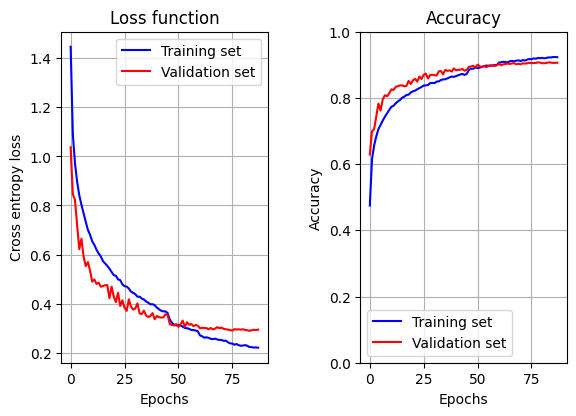

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


# elegimos usar gpu
use_gpu = True
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# creamos una instancia del modelo
basic_cnn_model = G4_CIFAR10_CNN()
# creamos la loss function
loss_fn = nn.CrossEntropyLoss()
# movemos todo lo que haga falta al dispositivo que hayamos elegido
basic_cnn_model = basic_cnn_model.to(device)
loss_fn = loss_fn.to(device)
# inicializamos un valor de learning rate
learning_rate = 0.005
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.SGD(basic_cnn_model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=0.0001)

# determinamos el número de épocas por el que queremos entrenar
n_epochs = 100

# Definir batch size
batch_size = 64

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Crear DataLoaders para batching
train_loader = DataLoader(cifar10_training, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(cifar10_validation, batch_size=batch_size, shuffle=False)

# Con early stopping
model, train_loss, val_loss, train_acc, val_acc = G4_training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=basic_cnn_model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    validation_loader=validation_loader,
    device=device,
    is_fully_connected=False,
    early_stopping_patience=12, # <--- Nuevo parámetro opcional
    scheduler=scheduler
)

# ploteamos los resultados
plot_training_statistics(train_loss, val_loss, train_acc, val_acc)

In [12]:
# Encontrar en qué época se obtuvo el mejor validation loss
best_epoch = val_loss.index(min(val_loss)) + 1
best_val_loss = val_loss[best_epoch - 1]
best_val_acc = val_acc[best_epoch - 1]

print(f"\n📊 RESULTADOS DEL MEJOR MODELO:")
print(f"   Época: {best_epoch}")
print(f"   Validation Loss: {best_val_loss:.4f}")
print(f"   Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Training Loss: {train_loss[best_epoch - 1]:.4f}")
print(f"   Training Accuracy: {train_acc[best_epoch - 1]:.4f} ({train_acc[best_epoch - 1]*100:.2f}%)")


📊 RESULTADOS DEL MEJOR MODELO:
   Época: 84
   Validation Loss: 0.2893
   Validation Accuracy: 0.9073 (90.73%)
   Training Loss: 0.2233
   Training Accuracy: 0.9223 (92.23%)


### 4. Evaluación sobre nuevos datos

A continuación les dejamos código que les permite abrir una serie de imágenes nuevas sobre las que podrían validar el algoritmo que implementaron.

Tienen que desarrollar las rutinas necesarias para:
* Convertir estas imágenes a tensores con los tamaños adecuados para poder procesarlos.
* Normalizarlos (utilizando las estadísticas que calculamos sobre los datos de entrenamiento).
* Iterar imagen por imagen y obtener su etiqueta utilizando la red neuronal convolucional entrenada.
* Calcular una o varias métricas de evaluación.
* Mostrar algunos ejemplos de resultados correctos o errados.

In [13]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

# accedemos a los datos
images = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_data.npy'))
labels = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_labels.npy'))
# los ponemos con los ejes en el lugar que queremos
images = np.transpose(images, axes=(0,3,1,2))
# imprimimos los tamaños
print(images.shape)
print(labels.shape)

# ACA ABAJO TIENEN QUE IMPLEMENTAR LA SOLUCIÓN

(2021, 3, 32, 32)
(2021,)


In [14]:
# Estadísticas
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2470, 0.2435, 0.2616])

# Convertir a tensor (las imágenes ya están en formato correcto: N, C, H, W)
if images.max() > 1.0:
    images = images.astype(np.float32) / 255.0

images_tensor = torch.from_numpy(images).float()

# Normalizar
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())
images_normalized = normalize(images_tensor)

print(f"✅ Listo: {images_normalized.shape}")

✅ Listo: torch.Size([2021, 3, 32, 32])


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# cuando lo queremos volver a cargar, simplemente creamos una instancia del modelo
basic_cnn_model = G4_CIFAR10_CNN()


**Si entreno el modelo durante la ejecución de la notebook, puede ejecutar la siguiente instrucción, caso contrario, por favor no la ejecute y lea el siguiente texto**

In [ ]:
basic_cnn_model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

**Si se decide por algún motivo no entrenar el modelo y solo evaluarlo. Se puede cargar los pesos del mejor modelo desde Github. Si esta es su opción, descomente el siguiente código y ejecutelo.**



In [16]:
#import requests
#import torch
#from io import BytesIO
#url = "https://raw.githubusercontent.com/stevilca/VC/master/Modelo%20Final/best_model.pth"

#response = requests.get(url)
#state_dict = torch.load(BytesIO(response.content), map_location=device, weights_only=True)
#basic_cnn_model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
# Mover modelo al dispositivo
basic_cnn_model = basic_cnn_model.to(device)

EVALUACIÓN DEL MODELO EN CIFAR-10.1

📊 Configuración:
   Batch size: 64
   Total imágenes: 2021
   Número de clases: 10

🔄 Realizando predicciones...
   Procesados: 640/2021 (31.7%)
   Procesados: 1280/2021 (63.3%)
   Procesados: 1920/2021 (95.0%)
✅ Predicciones completadas: 2021 imágenes

🔍 Identificando imágenes correctas e incorrectas...
   ✔ Correctas:   1643
   ❌ Incorrectas: 378
✅ Clasificación correcta/incorrecta procesada

MÉTRICAS DE EVALUACIÓN

🎯 ACCURACY: 81.30%
   (1643/2021 correctas)

📊 MÉTRICAS PROMEDIO (Macro):
   Precision: 0.8151
   Recall:    0.8151
   F1-Score:  0.8141

📊 MÉTRICAS PROMEDIO (Weighted):
   Precision: 0.8144
   Recall:    0.8130
   F1-Score:  0.8127

📋 MÉTRICAS POR CLASE:
---------------------------------------------------------------------------
Clase        Precision    Recall       F1-Score     Support   
---------------------------------------------------------------------------
airplane     0.8325       0.7644       0.7970       208       
automob

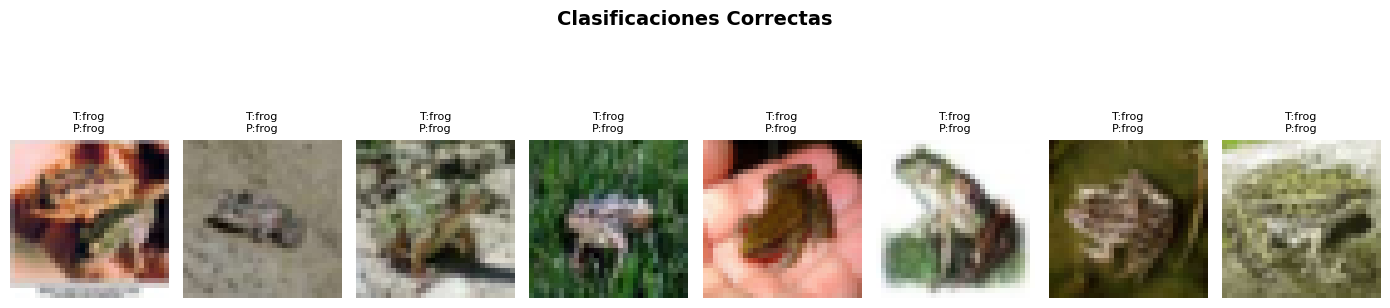


🖼 Mostrando imágenes incorrectamente clasificadas:


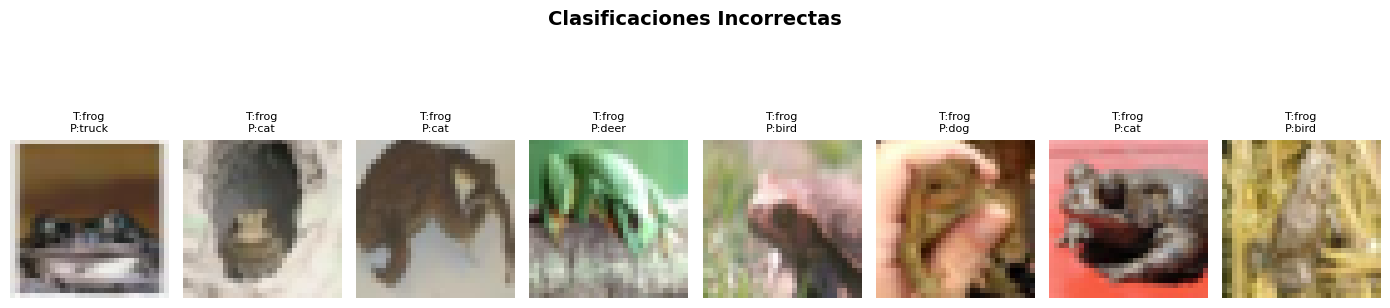


📈 Generando matriz de confusión...


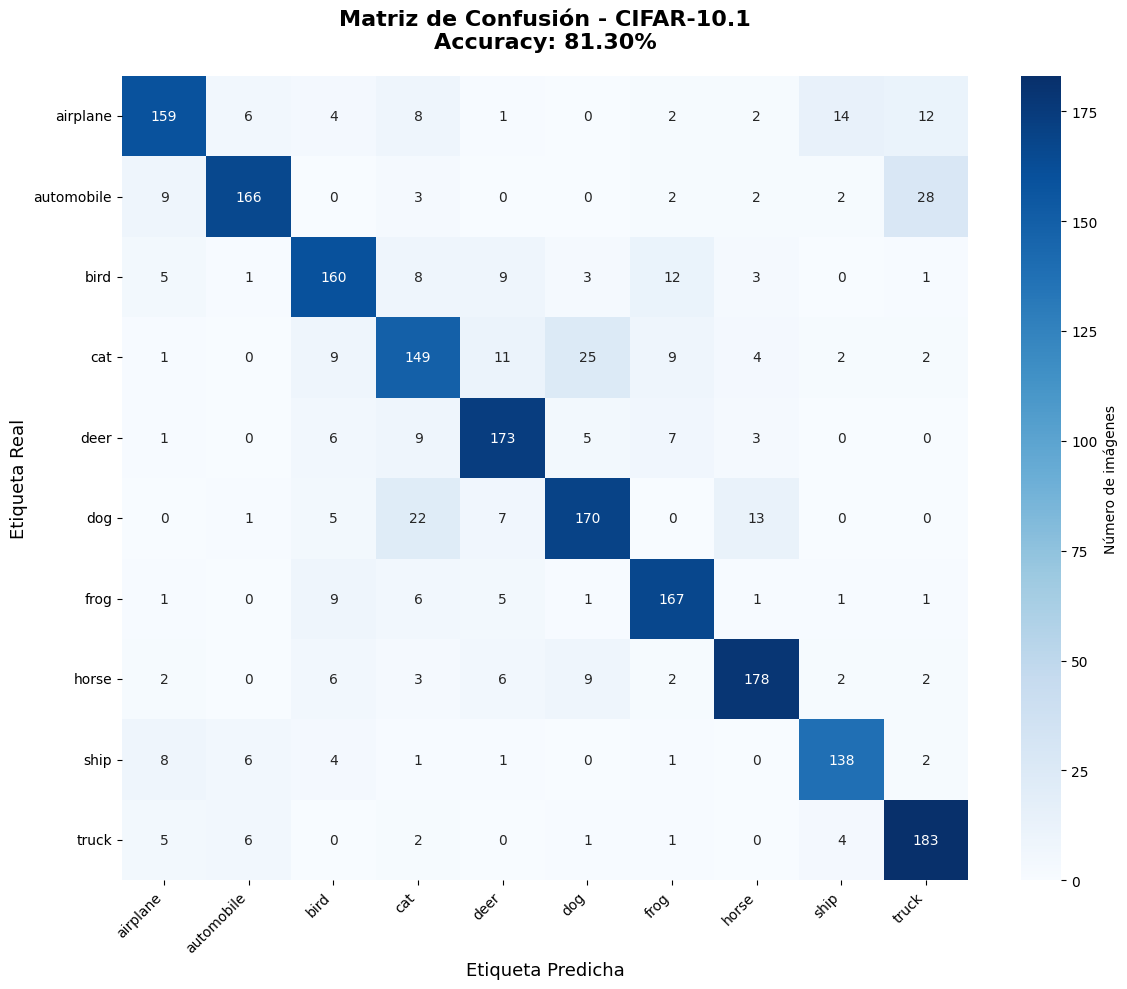

✅ Matriz de confusión generada

📈 Generando curvas ROC...


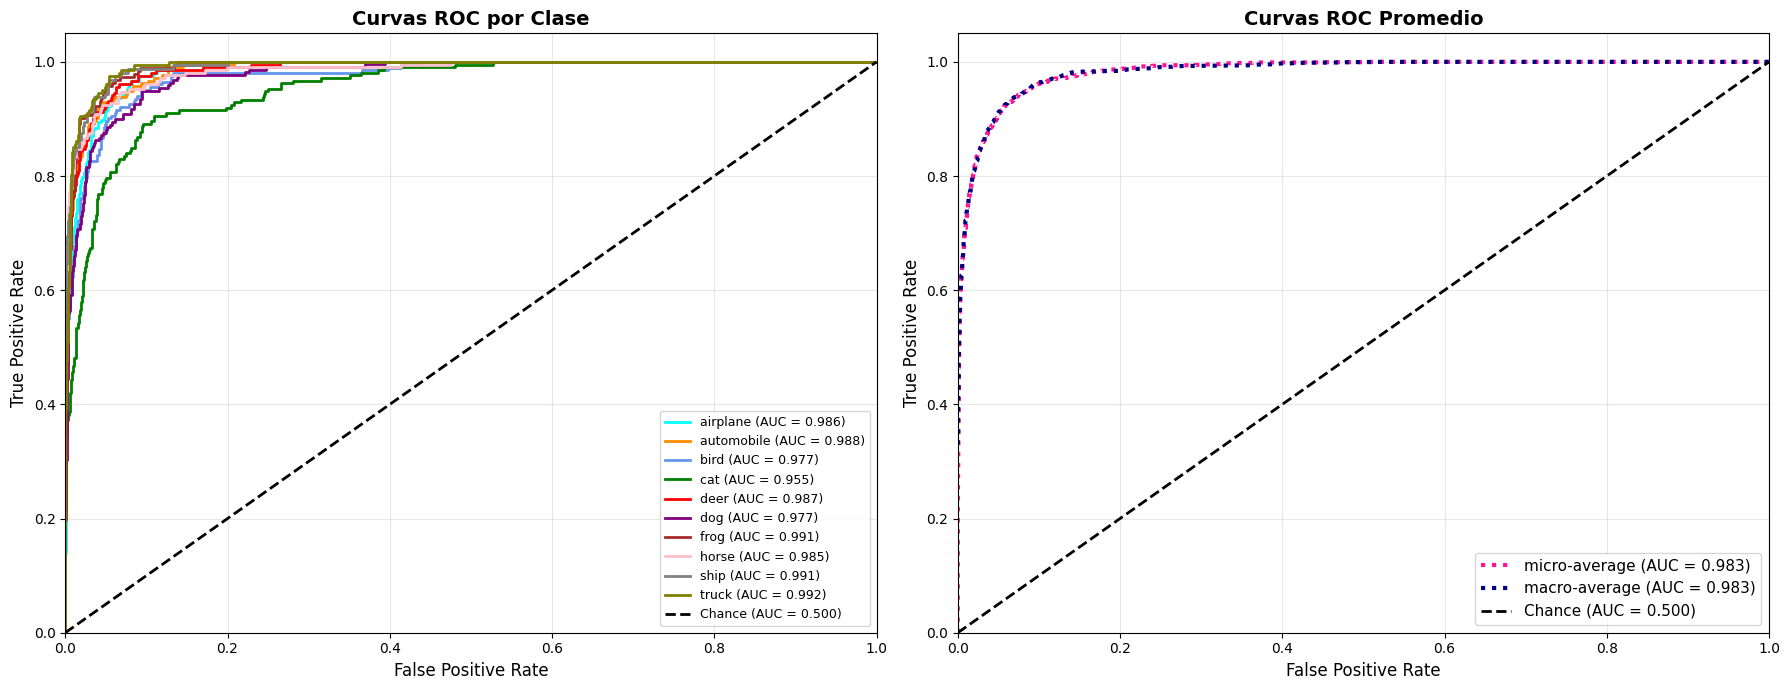

✅ Curvas ROC generadas

RESUMEN FINAL
Accuracy:         81.30%
Precision (macro): 0.8151
Recall (macro):    0.8151
F1-Score (macro):  0.8141
AUC (macro):       0.9831
AUC (micro):       0.9832

📊 AUC POR CLASE:
----------------------------------------
airplane     0.9860
automobile   0.9877
bird         0.9768
cat          0.9548
deer         0.9871
dog          0.9774
frog         0.9905
horse        0.9852
ship         0.9914
truck        0.9921
----------------------------------------


In [18]:

import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# ============================================
# CONFIGURACIÓN INICIAL
# ============================================

print("="*60)
print("EVALUACIÓN DEL MODELO EN CIFAR-10.1")
print("="*60)

# Inicializar tamaño de batch
batch_size = 64

# Poner el modelo en modo evaluación
basic_cnn_model.eval()

# Nombres de las clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(class_names)

# Crear dataset y dataloader
cifar_test_set = TensorDataset(images_normalized, torch.from_numpy(labels).long())
test_loader = DataLoader(cifar_test_set, batch_size=batch_size, shuffle=False)

print(f"\n📊 Configuración:")
print(f"   Batch size: {batch_size}")
print(f"   Total imágenes: {len(cifar_test_set)}")
print(f"   Número de clases: {n_classes}")

# ============================================
# INFERENCIA
# ============================================

print(f"\n🔄 Realizando predicciones...")

# Inicializar matrices y arreglos para guardar:
probabilities = np.zeros((len(cifar_test_set), n_classes))  # Probabilidades
predictions = np.zeros(len(cifar_test_set))                  # Predicciones
true_labels = np.zeros(len(cifar_test_set))                  # Labels verdaderos

# Sin calcular el gradiente...
with torch.no_grad():

    # Inicializar un contador de muestras
    num_samples = 0

    # Iterar por cada batch de test
    for i, (imgs, lbl) in enumerate(test_loader):

        # Obtener el número de imágenes en este batch
        num_outputs = imgs.shape[0]

        # Mover imágenes al dispositivo (GPU o CPU)
        imgs = imgs.to(device)

        # Obtener las predicciones (con softmax aplicado)
        probs = basic_cnn_model.predict(imgs)

        # Pasar la salida a CPU
        probs = probs.cpu()

        # Recuperar la clase más probable
        _, predicted = torch.max(probs, dim=1)

        # Guardar resultados en las matrices
        probabilities[num_samples:num_samples+num_outputs, :] = probs.numpy()
        predictions[num_samples:num_samples+num_outputs] = predicted.numpy()
        true_labels[num_samples:num_samples+num_outputs] = lbl.numpy()

        # Actualizar la cantidad de muestras que vamos llevando
        num_samples = num_samples + num_outputs

        # Mostrar progreso
        if (i + 1) % 10 == 0:
            print(f"   Procesados: {num_samples}/{len(cifar_test_set)} "
                  f"({num_samples/len(cifar_test_set)*100:.1f}%)")

print(f"✅ Predicciones completadas: {num_samples} imágenes")

# ============================================
# IDENTIFICAR IMÁGENES CORRECTAS E INCORRECTAS
# ============================================

print("\n🔍 Identificando imágenes correctas e incorrectas...")

correct_indices = np.where(predictions == true_labels)[0]
incorrect_indices = np.where(predictions != true_labels)[0]

print(f"   ✔ Correctas:   {len(correct_indices)}")
print(f"   ❌ Incorrectas: {len(incorrect_indices)}")


# estadísticas CIFAR-10
mean = torch.tensor([0.4914, 0.4822, 0.4465]).numpy()
std  = torch.tensor([0.2470, 0.2435, 0.2616]).numpy()

def denormalize(img_tensor):
    """Desnormaliza una imagen usando mean/std de CIFAR10"""
    img = img_tensor.numpy().transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_images(indices, title, n=8):
    """Muestra imágenes dadas por índices"""
    n = min(n, len(indices))
    plt.figure(figsize=(14, 4))
    plt.suptitle(title, fontsize=14, fontweight='bold')

    for i in range(n):
        idx = indices[i]
        img = denormalize(images_normalized[idx])
        true_lbl = int(true_labels[idx])
        pred_lbl = int(predictions[idx])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T:{class_names[true_lbl]}\nP:{class_names[pred_lbl]}",
                  fontsize=8)

    plt.tight_layout()
    plt.show()

print("✅ Clasificación correcta/incorrecta procesada")





# ============================================
# CALCULAR MÉTRICAS
# ============================================

print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN")
print("="*60)

# 1. Accuracy
accuracy = accuracy_score(true_labels, predictions)

# 2. Precision, Recall, F1-Score por clase
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, average=None, labels=range(n_classes)
)

# 3. Promedios macro (promedio simple)
precision_macro = np.mean(precision)
recall_macro = np.mean(recall)
f1_macro = np.mean(f1)

# 4. Promedios weighted (ponderado por support)
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
    true_labels, predictions, average='weighted'
)

# Mostrar resultados
print(f"\n🎯 ACCURACY: {accuracy*100:.2f}%")
print(f"   ({int(accuracy*len(true_labels))}/{len(true_labels)} correctas)")

print(f"\n📊 MÉTRICAS PROMEDIO (Macro):")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall:    {recall_macro:.4f}")
print(f"   F1-Score:  {f1_macro:.4f}")

print(f"\n📊 MÉTRICAS PROMEDIO (Weighted):")
print(f"   Precision: {precision_w:.4f}")
print(f"   Recall:    {recall_w:.4f}")
print(f"   F1-Score:  {f1_w:.4f}")

print(f"\n📋 MÉTRICAS POR CLASE:")
print("-" * 75)
print(f"{'Clase':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 75)

for i in range(n_classes):
    print(f"{class_names[i]:<12} {precision[i]:<12.4f} {recall[i]:<12.4f} "
          f"{f1[i]:<12.4f} {int(support[i]):<10}")

print("-" * 75)



# ============================================
# VISUALIZAR EJEMPLOS CORRECTOS E INCORRECTOS
# ============================================

print("\n🖼 Mostrando imágenes correctamente clasificadas:")
show_images(correct_indices, "Clasificaciones Correctas", n=8)

print("\n🖼 Mostrando imágenes incorrectamente clasificadas:")
show_images(incorrect_indices, "Clasificaciones Incorrectas", n=8)


# ============================================
# MATRIZ DE CONFUSIÓN
# ============================================

print(f"\n📈 Generando matriz de confusión...")

# Calcular matriz de confusión
cm = confusion_matrix(true_labels, predictions)

# Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Número de imágenes'},
            annot_kws={'size': 10})

plt.title(f'Matriz de Confusión - CIFAR-10.1\nAccuracy: {accuracy*100:.2f}%',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=13)
plt.xlabel('Etiqueta Predicha', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Matriz de confusión generada")

# ============================================
# CURVA ROC (One-vs-Rest)
# ============================================

print(f"\n📈 Generando curvas ROC...")

# Binarizar las etiquetas para One-vs-Rest
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(true_labels.astype(int), classes=range(n_classes))

# Calcular ROC curve y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular micro-average ROC curve y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcular macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: ROC de cada clase
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'brown', 'pink', 'gray', 'olive'])

for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.500)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('Curvas ROC por Clase', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=9)
ax1.grid(alpha=0.3)

# Plot 2: ROC promedio
ax2.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=3)

ax2.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=3)

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.500)')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Curvas ROC Promedio', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Curvas ROC generadas")

# ============================================
# RESUMEN FINAL CON AUC
# ============================================

print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)
print(f"Accuracy:         {accuracy*100:.2f}%")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1-Score (macro):  {f1_macro:.4f}")
print(f"AUC (macro):       {roc_auc['macro']:.4f}")
print(f"AUC (micro):       {roc_auc['micro']:.4f}")
print("="*60)

# AUC por clase
print(f"\n📊 AUC POR CLASE:")
print("-" * 40)
for i in range(n_classes):
    print(f"{class_names[i]:<12} {roc_auc[i]:.4f}")
print("-" * 40)